In [231]:
# title = "Make a Clasifier to Predict Transcription Factor Binding Sites"    
# author = "Cindy Pino-Barrios"
# date = "03-22-2023"
# description = "Transcription factors are proteins that bind DNA at promoters to drive gene expression. Most preferentially bind to specific sequences while ignoring others. Traditional methods to determine these sequences (called motifs) have assumed that binding sites in the genome are all independent. However, in some cases people have identified motifs where positional interdependencies exist."

# Making a Clasifier to Predict Transcription Factor Binding Sites

You will implement a multi-layer fully connected neural network using your `NeuralNetwork` class to predict whether a short DNA sequence is a binding site for the yeast transcription factor Rap1. The training data is incredibly imbalanced, with way fewer positive sequences than negative sequences, so you will implement a sampling scheme to ensure that class imbalance does not affect training. As in step 2, all of the following work should be done in a Jupyter Notebook.

### To-do

* Use the `read_text_file` function from `io.py` to read in the 137 positive Rap1 motif examples.
* Use the `read_fasta_file` function from `io.py` to read in all the negative examples. Note that these sequences are much longer than the positive sequences, so you will need to process them to the same length.
* Balance your classes using your `sample_seq` function and explain why you chose the sampling scheme you did.
* One-hot encode the data using your `one_hot_encode_seqs` function.
* Split the data into training and validation sets.
* Generate an instance of your `NeuralNetwork` class with an appropriate architecture.
* Train your neural network on the training data.
* Plot your training and validation loss by epoch.
* Report the accuracy of your classifier on your validation dataset.
* Explain your choice of loss function and hyperparameters.

In [320]:
# Import the necessary packages and modules 

from nn.nn import NeuralNetwork
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.io import read_text_file, read_fasta_file

In [321]:
# Import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

## Read and Process the data

In [339]:
# Use the read_text_file function to read in the data from the file "data/rap1-lieb-positives.txt"
# and store the result in the variable pos_seqs

pos_seqs = read_text_file("data/rap1-lieb-positives.txt")

# Use the read_fasta_file function to read in the data from the file "data/yeast-upstream-1k-negative.fa"
# and store the result in the variable neg_seqs

neg_seqs = read_fasta_file("data/yeast-upstream-1k-negative.fa")

# Use the sample_seqs function to sample the negative sequences to account for class imbalance
# and store the result in the variables neg_seqs_sampled and neg_labels_sampled

# Generate a list to store processed sequences 
neg_seqs_sampled = []

# Positive sequences are shorter than negative sequences, so we need to sample the negative sequences to account for class imbalance

post_seqs_len = len(pos_seqs[0])

# For the negative sequences, I will iterate through the list and only add the sequences that are the same length as the positive sequences and then add them to the negatve_seqs_sampled list

for seq in neg_seqs:
    for i in range(len(seq) - post_seqs_len + 1):
        if len(seq[i:i+post_seqs_len]) == post_seqs_len:
            neg_seqs_sampled.append(seq[i:i+post_seqs_len])


In [340]:
seqs = pos_seqs + neg_seqs_sampled

# Generate a list to store the labels for the sequences
pos_labels = []

# For the positive sequences, I will add a 1 to the labels list
# len of positive labels should be the same as the length of the positive sequences
for seq in pos_seqs:
    pos_labels.append(1)


# For the negative sequences, I will add a 0 to the labels list
# len of negative labels should be the same as the length of the negative sequences
neg_labels = []

for seq in neg_seqs_sampled:
    neg_labels.append(0)

# Combine the positive and negative labels into one list

labels = pos_labels + neg_labels

# Use the 'sample_seqs' function 

assert len(seqs) == len(labels)

#seqs, labels = sample_seqs(seqs, labels)

In [341]:
# Create two function calls to sample_seqs, one for the positive sequences and one for the negative sequences. 
# Imports
import numpy as np
from typing import List, Tuple
from numpy.typing import ArrayLike

def sample_seqs(seqs: List[str], labels: List[bool]) -> Tuple[List[str], List[bool]]:
    """
    This function should sample the given sequences to account for class imbalance. 
    Consider this a sampling scheme with replacement.
    
    Args:
        seqs: List[str]
            List of all sequences.
        labels: List[bool]
            List of positive/negative labels

    Returns:
        sampled_seqs: List[str]
            List of sampled sequences which reflect a balanced class size
        sampled_labels: List[bool]
            List of labels for the sampled sequences
    """
    # Get the number of positive and negative labels
    num_pos = sum(labels)
    num_neg = len(labels) - num_pos

    # Get the number of sequences to sample
    num_to_sample = min(num_pos, num_neg)

    # Create a list to store the sampled sequences
    sampled_seqs = []

    # Create a list to store the sampled labels

    sampled_labels = []

    # Iterate through the sequences and labels
    for seq, label in zip(seqs, labels):
        # If the label is positive and the number of positive samples is less than the number of samples to take
        if label and num_pos > 0:
            # Add the sequence and label to the sampled sequences and labels
            sampled_seqs.append(seq)
            sampled_labels.append(label)
            # Decrement the number of positive samples
            num_pos -= 1
        # If the label is negative and the number of negative samples is less than the number of samples to take
        elif not label and num_neg > 0:
            # Add the sequence and label to the sampled sequences and labels
            sampled_seqs.append(seq)
            sampled_labels.append(label)
            # Decrement the number of negative samples
            num_neg -= 1

    assert len(sampled_seqs) == len(sampled_labels)

    # Return the sampled sequences and labels

      
    return sampled_seqs, sampled_labels



In [342]:
seqs

['ACATCCGTGCACCTCCG',
 'ACACCCAGACATCGGGC',
 'CCACCCGTACCCATGAC',
 'GCACCCATACATTACAT',
 'ACATCCATACACCCTCT',
 'ACACCCTTACACTTTTA',
 'GCATCCGTGCCTCCCAC',
 'AAACCCATGCACAGTGA',
 'ACATCCGTGCACCATTT',
 'ACACCCATACATACGGA',
 'ACACCCACACCCCGGGC',
 'ACCTCCGTACACCAATC',
 'ACACCCATACATGTTGA',
 'TGACCCATACATTTCCT',
 'ACATCCGTACATCAGAA',
 'AAACCCATACATATCTT',
 'TCACCCAGTCATCCAAC',
 'AGACCCACACACCGCAT',
 'TAGCCCATACACCGCAG',
 'ACACCCACACCCCTCAT',
 'ACACCCACGCCCCGCAA',
 'GAACCCACACCTCTCAC',
 'GCACCCACACATCGCAT',
 'AAATCCGTGCACCGCAT',
 'AAACCCATGCACCTCCA',
 'ACACCCATTCACCGCAC',
 'ACATCCGTGCACTGTGG',
 'ACATCCATACATTCGGT',
 'ACACCCATACATTTATA',
 'ACACCCAGACACCTCAA',
 'GCACCCGTACCCCACAA',
 'ACATCCGAACACCAAAT',
 'ACACCCATACCTCTCAG',
 'GCACCCGCACACCGCAG',
 'ACACCCACACATTTACA',
 'AAACCCATACAATATAT',
 'ACATCCGTACACTTTTG',
 'CCGCCCATACACCCCAT',
 'GCACCCACACACCGGAC',
 'ACACCCAAACATTAGGG',
 'CCATCCATACATTTTGG',
 'GCACCCATGCACCTCAC',
 'GAACCCATTCACCACAT',
 'CCATCCATACATGTTCA',
 'ACACCCACACATATCTA',
 'AAATCCGT

In [325]:
seqs, labels = sample_seqs(seqs, labels)


In [335]:
# Use the one_hot_encode_seqs function to one-hot encode the positive and negative sequences

def one_hot_encode_seqs(seq_arr: List[str]) -> ArrayLike:
    """
    This function generates a flattened one-hot encoding of a list of DNA sequences
    for use as input into a neural network.

    Args:
        seq_arr: List[str]
            List of sequences to encode.

    Returns:
        encodings: ArrayLike
            Array of encoded sequences, with each encoding 4x as long as the input sequence.
            For example, if we encode:
                A -> [1, 0, 0, 0]
                T -> [0, 1, 0, 0]
                C -> [0, 0, 1, 0]
                G -> [0, 0, 0, 1]
            Then, AGA -> [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0].
    """
    # Create a dictionary to map each nucleotide to a one-hot encoding

    nucleotide_dict = {"A": [1, 0, 0, 0], 
                       "T": [0, 1, 0, 0], 
                       "C": [0, 0, 1, 0], 
                       "G": [0, 0, 0, 1]}

    # Create a list to store the one-hot encodings
    encodings = []
    
    # Loop through each sequence in the list of sequences

    for seq in seq_arr:
        # Create a list to store the one-hot encoding for the current sequence
        seq_encoding = []

        # Loop through each nucleotide in the sequence
        for nucleotide in seq:
            # Append the one-hot encoding for the current nucleotide to the current sequence encoding
            seq_encoding.extend(nucleotide_dict[nucleotide])

        # Append the current sequence encoding to the list of encodings
        encodings.append(seq_encoding)

    return np.array(encodings)





In [328]:
# import hot encoder function from preprocessing.py
#from nn.preprocess import one_hot_encode_seqs

In [336]:
# Use the one_hot_encode_seqs function of seqs 

X = one_hot_encode_seqs(seqs) # One-hot encode the sequences
y = np.array(labels, dtype=int) # Convert the labels to a numpy array


In [337]:
X

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [338]:
X.shape, y.shape

((3109826, 68), (3109826,))

In [ ]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2487860, 68), (621966, 68), (2487860,), (621966,))

### Autoencoder

In [ ]:
# Imports
import numpy as np
from typing import List, Dict, Tuple, Union

from matplotlib import pyplot as plt
from numpy.typing import ArrayLike

class NeuralNetwork:
    """
    This is a class that generates a fully-connected neural network.
    Parameters:
        nn_arch: List[Dict[str, float]]
            A list of dictionaries describing the layers of the neural network.
            e.g. [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 8, 'activation:': 'sigmoid'}]
            will generate a two-layer deep network with an input dimension of 64, a 32 dimension hidden layer, and an 8 dimensional output.
        lr: float
            Learning rate (alpha).
        seed: int
            Random seed to ensure reproducibility.
        batch_size: int
            Size of mini-batches used for training.
        epochs: int
            Max number of epochs for training.
        loss_function: str
            Name of loss function.
    Attributes:
        arch: list of dicts
            (see nn_arch above)
    """

    def __init__(self, nn_arch: List[Dict[str, Union[int, str]]],
                 lr: float, seed: int, batch_size: int, epochs: int, loss_function: str):

        # Save architecture
        self.arch = nn_arch

        # Save hyperparameters
        self._lr = lr
        self._seed = seed
        self._epochs = epochs
        self._loss_func = loss_function
        self._batch_size = batch_size

        # Initialize the parameter dictionary for use in training
        self._param_dict = self._init_params()

    def _init_params(self) -> Dict[str, ArrayLike]:
        """
        DO NOT MODIFY THIS METHOD! IT IS ALREADY COMPLETE!
        This method generates the parameter matrices for all layers of
        the neural network. This function returns the param_dict after
        initialization.
        Returns:
            param_dict: Dict[str, ArrayLike]
                Dictionary of parameters in neural network.
        """

        # Seed NumPy
        np.random.seed(self._seed)

        # Define parameter dictionary
        param_dict = {}

        # Initialize each layer's weight matrices (W) and bias matrices (b)
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            param_dict['W' + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
            param_dict['b' + str(layer_idx)] = np.random.randn(output_dim, 1) * 0.1

        return param_dict
    
    def _single_forward(self, W_curr: ArrayLike, b_curr: ArrayLike,
                        A_prev: ArrayLike, activation: str) -> Tuple[ArrayLike, ArrayLike]:
        """
        This method is used for a single forward pass on a single layer.
        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            activation: str
                Name of activation function for current layer.
        Returns:
            A_curr: ArrayLike
                Current layer activation matrix.
            Z_curr: ArrayLike
                Current layer linear transformed matrix.
        """

        # Set current layer Z matrix to be the weights matrix multiplied by the previous layer's activation matrix plus the bias matrix
        Z_curr = np.dot(W_curr, A_prev) + b_curr

        # Set current layer activation matrix to be the activation function of the current layer Z matrix
        # If the activation function is relu, use the relu function 
        if activation == 'relu':
            A_curr = self._relu(Z_curr)
        # If the activation function is sigmoid, use the sigmoid function
        elif activation == 'sigmoid':
            A_curr = self._sigmoid(Z_curr)
        # If neither relu nor sigmoid, raise an exception
        else:
            raise Exception('Non-supported activation function. Please specify either "relu" or "sigmoid" as activation functions.')
        
        return A_curr, Z_curr # return Tuple[ArrayLike, ArrayLike] of current layer activation matrix and current layer linear transformed matrix
    
    def forward(self, X: ArrayLike) -> Tuple[ArrayLike, Dict[str, ArrayLike]]:
        """
        This method is responsible for one forward pass of the entire neural network.
        Args:
            X: ArrayLike
                Input matrix with shape [batch_size, features].
        Returns:
            output: ArrayLike
                Output of forward pass.
            cache: Dict[str, ArrayLike]:
                Dictionary storing Z and A matrices from `_single_forward` for use in backprop.
        """

        # Initialize cache dictionary
        cache = {'A0': X}

        # Set current layer's activation matrix to be the input matrix
        A_curr = X

        # Loop through each layer in the neural network
        for idx, layer in enumerate(self.arch):
            
            # Set current layer's activation matrix to be the previous layer's activation matrix
            A_prev = A_curr

            # Get index of first layer (layer 1)
            layer_idx = idx + 1
            
            # Extract corresponding weight matrix and bias matrix for current layer from parameter dictionary
            W_curr = self._param_dict['W' + str(layer_idx)]
            b_curr = self._param_dict['b' + str(layer_idx)]
            activation = layer['activation']

            # Perform a single forward pass on the current layer
            A_curr, Z_curr = self._single_forward(W_curr, b_curr, A_prev, activation)

            # Store current layer's Z matrix and A matrix in cache
            cache['Z' + str(layer_idx)] = Z_curr
            cache['A' + str(layer_idx)] = A_curr

        # Set output to be the final layer's activation matrix
        output = A_curr.T

        return output, cache
    
    def _single_backprop(self, W_curr: ArrayLike, b_curr: ArrayLike, Z_curr: ArrayLike, A_prev: ArrayLike,
                         dA_curr: ArrayLike, activation_curr: str) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
        """
        This method is used for a single backprop pass on a single layer.
        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            Z_curr: ArrayLike
                Current layer linear transform matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            dA_curr: ArrayLike
                Partial derivative of loss function with respect to current layer activation matrix.
            activation_curr: str
                Name of activation function of layer.
        Returns:
            dA_prev: ArrayLike
                Partial derivative of loss function with respect to previous layer activation matrix.
            dW_curr: ArrayLike
                Partial derivative of loss function with respect to current layer weight matrix.
            db_curr: ArrayLike
                Partial derivative of loss function with respect to current layer bias matrix.
        """

        # If the activation function is relu, use the relu derivative function
        if activation_curr == 'relu':
            activation_func = self._relu_backprop(dA_curr, Z_curr)

        # If the activation function is sigmoid, use the sigmoid derivative function
        elif activation_curr == 'sigmoid':
            activation_func = self._sigmoid_backprop(dA_curr, Z_curr)

        # If neither relu nor sigmoid, raise an exception
        else:
            raise Exception('Non-supported activation function. Please specify either "relu" or "sigmoid" as activation functions.')
        
        # Set current layer's partial derivative of loss function with respect to current layer's Z matrix to be the activation function derivative multiplied by the current layer's partial derivative of loss function with respect to current layer's activation matrix
        dZ_curr = activation_func

        # Compute the gradient for the current layer
        dW_curr = np.dot(dZ_curr, A_prev.T) / np.shape(A_prev)[1]
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / np.shape(A_prev)[1]
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr # return Tuple[ArrayLike, ArrayLike, ArrayLike] of partial derivative of loss function with respect to previous layer activation matrix, partial derivative of loss function with respect to current layer weight matrix, and partial derivative of loss function with respect to current layer bias matrix
    
    def backprop(self, y: ArrayLike, y_hat: ArrayLike, cache: Dict[str, ArrayLike]):
        """
        This method is responsible for the backprop of the whole fully connected neural network.
        Args:
            y (array-like):
                Ground truth labels.
            y_hat: ArrayLike
                Predicted output values.
            cache: Dict[str, ArrayLike]
                Dictionary containing the information about the
                most recent forward pass, specifically A and Z matrices.
        Returns:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from this pass of backprop.
        """

        # Initialize gradient dictionary
        grad_dict = {}

        # Set the partial derivative of loss function with respect to final layer activation matrix to be the difference between the predicted output and the ground truth labels
        if self._loss_func == 'mse':
            dA_prev = self._mean_squared_error_backprop(y, y_hat)
        elif self._loss_func == 'bce':
            dA_prev = self._binary_cross_error_backprop(y, y_hat)
        else:
            raise Exception('Non-supported loss function. Please specify either "mse" or "bce" as loss functions.')

        # Loop through each layer in the neural network
        for layer_idx_prev, layer in reversed(list(enumerate(self.arch))):

            # Get index of current layer
            layer_idx_curr = layer_idx_prev + 1
            dA_curr = dA_prev

            # Extract corresponding activation matrix and Z matrix for current layer from cache
            if layer_idx_prev == 0:
                A_prev = cache['A0']
            else:
                A_prev = cache['A' + str(layer_idx_prev)]

            # Extract corresponding weight matrix and bias matrix for current layer from parameter dictionary
            W_curr = self._param_dict['W' + str(layer_idx_curr)]
            b_curr = self._param_dict['b' + str(layer_idx_curr)]
            Z_curr = cache['Z' + str(layer_idx_curr)]

            # Extract activation function for current layer
            activation_curr = layer['activation']

            # Perform a single backprop pass on the current layer
            dA_prev, dW_curr, db_curr = self._single_backprop(W_curr, b_curr, Z_curr, A_prev, dA_prev, activation_curr)

            # Store current layer's partial derivative of loss function with respect to current layer's weight matrix, current layer's partial derivative of loss function with respect to current layer's bias matrix, and previous layer's partial derivative of loss function with respect to previous layer's activation matrix in gradient dictionary
            grad_dict['dW' + str(layer_idx_curr)] = dW_curr
            grad_dict['db' + str(layer_idx_curr)] = db_curr
            grad_dict['dA' + str(layer_idx_prev)] = dA_prev

        return grad_dict
    
    def _update_params(self, grad_dict: Dict[str, ArrayLike]):
        """
        This function updates the parameters in the neural network after backprop. This function
        only modifies internal attributes and does not return anything
        Args:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from most recent round of backprop.
        """

        # Loop through each layer in the neural network and update the parameters for W and b
        for layer_idx, layer in enumerate(self.arch, 1):
            self._param_dict['W' + str(layer_idx)] -= self._lr * grad_dict['dW' + str(layer_idx)]
            self._param_dict['b' + str(layer_idx)] -= self._lr * grad_dict['db' + str(layer_idx)]

    def fit(self, X_train: ArrayLike, y_train: ArrayLike,
            X_val: ArrayLike, y_val: ArrayLike) -> Tuple[List[float], List[float]]:
        """
        This function trains the neural network by backpropagation for the number of epochs defined at
        the initialization of this class instance.
        Args:
            X_train: ArrayLike
                Input features of training set.
            y_train: ArrayLike
                Labels for training set.
            X_val: ArrayLike
                Input features of validation set.
            y_val: ArrayLike
                Labels for validation set.
        Returns:
            per_epoch_loss_train: List[float]
                List of per epoch loss for training set.
            per_epoch_loss_val: List[float]
                List of per epoch loss for validation set.
        """

        # Initialize lists of training and validation losses
        per_epoch_loss_train = []
        per_epoch_loss_val = []

        # Iterate across each epoch


        for epoch in range((self._epochs)):
            # Shuffle indices to randomly select batches
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)

            # Initialize list to keep track of different batches
            batches = []

            # Iterate through rows of X_train in increments of batch size
            for i in range(0, X_train.shape[0], self._batch_size):
                X_batch = X_train[i:i + self._batch_size]  # Use batch indices to select corresponding rows from X_train
                y_batch = y_train[i:i + self._batch_size]  # Use batch indices to select corresponding rows from y_train
                batches.append((X_batch, y_batch))  # Add the batch to the list of batches

            # Iterate through the X and y batches
            for X_batch, y_batch in batches:
                X_batch = X_batch.T  # Transpose each X batch
                y_batch = y_batch.T  # Transpose each X batch
                y_hat, cache = self.forward(X_batch)  # Forward pass on X batches
                grad_dict = self.backprop(y_batch, y_hat, cache)  # Backpropagate using y_batches
                self._update_params(grad_dict)  # Update parameters using values stored from backpropagation

            # Calculate predictions from training and validation sets
            y_hat_train = self.predict(X_train)
            y_hat_val = self.predict(X_val)

            # Calculate training and validation losses using user-defined loss function
            if "bce" in self._loss_func:
                train_loss = self._binary_cross_error(y_train.T, y_hat_train.T)
                val_loss = self._binary_cross_error(y_val.T, y_hat_val.T)
            elif "mse" in self._loss_func:
                train_loss = self._mean_squared_error(y_train.T, y_hat_train.T)
                val_loss = self._mean_squared_error(y_val.T, y_hat_val.T)
            else:
                raise NameError("Loss function name is not defined. "
                                "Choose either mean squared error or binary cross entropy as loss function.")

            # Append calculated loss to per epoch loss lists
            per_epoch_loss_train.append(train_loss)
            per_epoch_loss_val.append(val_loss)

        return per_epoch_loss_train, per_epoch_loss_val
                
    
    def predict(self, X: ArrayLike) -> ArrayLike:
        """
        This function makes predictions for the input features.
        Args:
            X: ArrayLike
                Input features.
        Returns:
            y_hat: ArrayLike
                Predicted output values.
        """
    
        # Perform forward pass
        y_hat, _ = self.forward(X.T)
    
        return y_hat
    
    def _sigmoid(self, Z: ArrayLike) -> ArrayLike:
        """
        Sigmoid activation function.
        Args:
            Z: ArrayLike
                Output of layer linear transform.
        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """

        nl_transform = 1 / (1 + np.exp(-Z))
    
        return nl_transform
    
    def _sigmoid_backprop(self, dA: ArrayLike, Z: ArrayLike):
        """
        Sigmoid derivative for backprop.
        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.
        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """

        sig = self._sigmoid(Z)
        dZ = dA * sig * (1 - sig)
    
        return dZ
    
    def _relu(self, Z: ArrayLike) -> ArrayLike:
        """
        ReLU activation function.
        Args:
            Z: ArrayLike
                Output of layer linear transform.
        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        return np.maximum(0, Z)
    
    def _relu_backprop(self, dA: ArrayLike, Z: ArrayLike) -> ArrayLike:
        """
        ReLU derivative for backprop.
        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.
        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """

        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    
        return dZ
    
    def _binary_cross_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Binary cross entropy loss function.
        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.
        Returns:
            loss: float
                Average loss over mini-batch.
        """

        loss = -(1 / y.shape[1] * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
    
        return loss
    
    def _binary_cross_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Binary cross entropy loss function derivative for backprop.
        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.
        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        dA = - (np.divide(y, y_hat.T) - np.divide((1 - y), (1 - y_hat.T)))
        return dA
    
    def _mean_squared_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Mean squared error loss.
        Args:
            y: ArrayLike
                Ground truth output.
            y_hat: ArrayLike
                Predicted output.
        Returns:
            loss: float
                Average loss of mini-batch.
        """
        

        loss = (1 / (2 * y.shape[0]) * np.sum(np.square(y_hat - y)))
    
        return loss
    
    def _mean_squared_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Mean square error loss derivative for backprop.
        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.
        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        # Derivative of the MSE loss function

        dA = (2 / y.shape[0] * y_hat.T - y)

   
        return dA

## Test

In [ ]:
# Create a NeuralNetwork object

# Parameters
nn_arch = [{'input_dim': 68, 'output_dim': 32, 'activation': 'relu'},
              {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
                {'input_dim': 16, 'output_dim': 4, 'activation': 'sigmoid'},    
                {'input_dim': 4, 'output_dim': 1, 'activation': 'sigmoid'}]

lr = 0.01
seed = 42
batch_size = 32
epochs = 10
loss_func = 'mse'



# Create a NeuralNetwork object
nn = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_func)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2487860, 68), (621966, 68), (2487860,), (621966,))

In [ ]:
train_loss, val_loss = nn.fit(X_train, y_train, X_test, y_test)

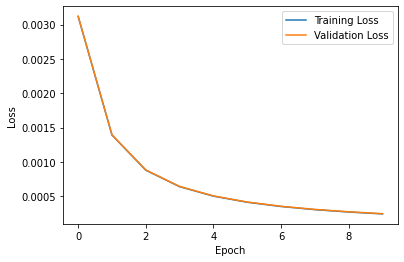

In [ ]:
# Plot training and validation loss by epoch
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# print the average reconstruction error over the validation set
print(f'Average Training Error: {np.mean(train_loss)}')
print(f'Average Validation Error: {np.mean(val_loss)}')

Average Training Error: 0.000809867988613527
Average Validation Error: 0.0008132377470897109


In [ ]:
# Create a for loop to determine which parameters to use for the NeuralNetwork class instance to get the lowest loss on the validation set 

## Parameters:

seed = 42
lr = [0.01, 0.001, 0.0001]
batch_size = [32, 64, 128]
epochs = [10, 20, 30]
loss_func = 'mse'

# Create a for loop to determine which parameters to use for the NeuralNetwork class instance to get the lowest loss on the validation set
hyperparams = []

for i in lr:
    for j in batch_size:
        for k in epochs:
            nn = NeuralNetwork(nn_arch, i, seed, j, k, loss_func)
            train_loss, val_loss = nn.fit(X_train, y_train, X_test, y_test)
            hyperparams.append((i, j, k, np.mean(val_loss)))
            print(f'Learning Rate: {i}, Batch Size: {j}, Epochs: {k}, Average Validation Error: {np.mean(val_loss)}')






Learning Rate: 0.01, Batch Size: 32, Epochs: 10, Average Validation Error: 0.0008132377470897109
Learning Rate: 0.01, Batch Size: 32, Epochs: 20, Average Validation Error: 0.0004895137276689162
Learning Rate: 0.01, Batch Size: 32, Epochs: 30, Average Validation Error: 0.00036099330725822027
Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Average Validation Error: 0.004066087726115059
Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Average Validation Error: 0.00238424152953938


KeyboardInterrupt: 

In [ ]:
# Create a NeuralNetwork object with the best hyperparameters

autoencoder = NeuralNetwork(nn_arch, 0.01, 42, 32, 10, 'mse')

In [ ]:
train_loss, val_loss = autoencoder.fit(X_train, X_train, X_test, X_test)

ValueError: shapes (4,1) and (68,32) not aligned: 1 (dim 1) != 68 (dim 0)

In [ ]:
# Plot training and validation loss by epoch
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()